# SHAP 
## with structured data regression

**Explainable AI with TensorFlow, Keras and SHAP**

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. [Learn more](https://shap.readthedocs.io/en/latest/index.html)  

*This is mainly based on the Keras tutorial ["Structured data classification from scratch"](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by François Chollet and ["Census income classification with Keras"](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html#Census-income-classification-with-Keras) by Scott Lundberg.*

## Setup

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import shap

tf.__version__

/Users/hendrikpfeifer/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.8.1'

In [3]:
# print the JS visualization code to the notebook
shap.initjs()

## Data

### Data import


- Let's download the data and load it into a Pandas dataframe:

In [4]:
df = pd.read_csv("car_prices_clean.csv", on_bad_lines="skip")
df = df.drop(columns=['Unnamed: 0', "seller"])

In [5]:
df.head()

,year,brand,model,type,state,condition,miles,color,interior,sellingprice
0,2015,kia,sorento,suv,ca,5.0,16639.0,white,black,21500
1,2015,kia,sorento,suv,ca,5.0,9393.0,white,beige,21500
2,2014,bmw,3 series,sedan,ca,4.5,1331.0,gray,black,30000
3,2015,volvo,s60,sedan,ca,4.1,14282.0,white,black,27750
4,2014,bmw,6 series gran coupe,sedan,ca,4.3,2641.0,gray,black,67000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533660 entries, 0 to 533659
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          533660 non-null  int64  
 1   brand         533660 non-null  object 
 2   model         533660 non-null  object 
 3   type          533660 non-null  object 
 4   state         533660 non-null  object 
 5   condition     533660 non-null  float64
 6   miles         533660 non-null  float64
 7   color         533660 non-null  object 
 8   interior      533660 non-null  object 
 9   sellingprice  533660 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 40.7+ MB


### Data preparation

### Create labels and features

We need to encode our categorical features as one-hot numeric features (dummy variables):

In [7]:
dummies = pd.get_dummies(df[["year","brand", "model", "type", "state", "condition", "color", "interior"]])

In [8]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533660 entries, 0 to 533659
Columns: 943 entries, year to interior_—
dtypes: float64(1), int64(1), uint8(941)
memory usage: 487.1 MB


In [9]:
print(dummies.head())


   year  condition  brand_acura  brand_aston martin  brand_audi  \
0  2015        5.0            0                   0           0   
1  2015        5.0            0                   0           0   
2  2014        4.5            0                   0           0   
3  2015        4.1            0                   0           0   
4  2014        4.3            0                   0           0   

   brand_bentley  brand_bmw  brand_buick  brand_cadillac  brand_chevrolet  \
0              0          0            0               0                0   
1              0          0            0               0                0   
2              0          1            0               0                0   
3              0          0            0               0                0   
4              0          1            0               0                0   

   ...  interior_green  interior_off-white  interior_orange  interior_purple  \
0  ...               0                   0            

In [10]:
# make target variable

y = df['sellingprice']

In [11]:
X_numerical = df.drop(["sellingprice","year", "brand", "model", "type", "state", "condition", "color", "interior"], axis=1).astype('float64')

In [12]:
list_numerical = X_numerical.columns
list_numerical

Index(['miles'], dtype='object')

In [13]:
# Create all features

X = pd.concat([X_numerical, dummies], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533660 entries, 0 to 533659
Columns: 944 entries, miles to interior_—
dtypes: float64(2), int64(1), uint8(941)
memory usage: 491.1 MB


### Data splitting

- Let's split the data into a training and test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
X_train.head()

,miles,year,condition,brand_acura,brand_aston martin,brand_audi,brand_bentley,brand_bmw,brand_buick,brand_cadillac,...,interior_green,interior_off-white,interior_orange,interior_purple,interior_red,interior_silver,interior_tan,interior_white,interior_yellow,interior_—
228789,29616.0,2014,3.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492477,61597.0,2013,3.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108042,11961.0,2012,4.7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146764,37045.0,2011,3.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
312891,42300.0,2012,2.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature preprocessing

In [16]:
scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## Model

Now we can build the model using the Keras sequential API:

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

2022-06-22 13:19:53.733152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(optimizer="adam", 
              loss ="mse", 
              metrics=["mean_absolute_error"])

In [19]:
# will stop training when there is no improvement in 3 consecutive epochs

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [20]:
model.fit(X_train, y_train, 
         epochs=50,
         validation_data=(X_test, y_test), 
         callbacks=[callback]
         )

Epoch 1/50
11674/11674 [==============================] - 23s 2ms/step - loss: 97076792.0000 - mean_absolute_error: 7187.8936 - val_loss: 90239728.0000 - val_mean_absolute_error: 6911.7607
Epoch 2/50
11674/11674 [==============================] - 22s 2ms/step - loss: 82532552.0000 - mean_absolute_error: 6563.0259 - val_loss: 66355832.0000 - val_mean_absolute_error: 5639.1455
Epoch 3/50
11674/11674 [==============================] - 24s 2ms/step - loss: 40327840.0000 - mean_absolute_error: 4116.4556 - val_loss: 33499380.0000 - val_mean_absolute_error: 3638.2261
Epoch 4/50
11674/11674 [==============================] - 22s 2ms/step - loss: 30577248.0000 - mean_absolute_error: 3510.2290 - val_loss: 29286292.0000 - val_mean_absolute_error: 3389.6111
Epoch 5/50
11674/11674 [==============================] - 17s 1ms/step - loss: 27400320.0000 - mean_absolute_error: 3301.7327 - val_loss: 26962206.0000 - val_mean_absolute_error: 3207.4656
Epoch 6/50
11674/11674 [==============================]

- Configure the model with Keras Model.compile:

Let's visualize our connectivity graph:

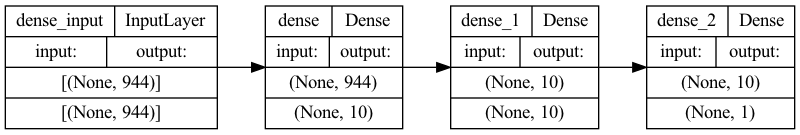

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)

print("MAE:", accuracy)

5004/5004 [==============================] - 4s 857us/step - loss: 13278642.0000 - mean_absolute_error: 2274.1196
MAE: 2274.11962890625


## Perform inference

- The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself. Let's demonstrate the process:

- Save the heart diseases classification model

In [23]:
model.save('shap_car_model-1')

2022-06-22 13:35:42.008015: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: shap_car_model-1/assets


- Load model

In [24]:
reloaded_model = tf.keras.models.load_model('shap_car_model-1')

In [25]:
predictions = reloaded_model.predict(X_train)

In [26]:
predictions

array([[30361.258],
       [14307.67 ],
       [28072.123],
       ...,
       [20672.85 ],
       [17868.303],
       [12858.137]], dtype=float32)

## SHAP

We use our model and a selection of 50 samples from the dataset to represent “typical” feature values (the so called background distribution).

In [27]:
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])

Now we use 500 perterbation samples to estimate the SHAP values for a given prediction (at index location 20). Note that this requires 500 * 50 evaluations of the model.

In [28]:
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)

The so called force plot below shows how each feature contributes to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. To learn more about force plots, take a look at this [Nature BME paper](https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D) from Lundberg et al. (2018).

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_train.iloc[20,:])

### Explain many predictions

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (see content below). Here, we repeat the above explanation process for 50 individuals.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in the dependent variable. Vertical dispersion at a single value of represents interaction effects with other features. 

In [30]:
shap_values50 = explainer.shap_values(X_train.iloc[50:100,:], nsamples=500)

100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


In [31]:
shap.force_plot(explainer.expected_value[0], shap_values50[0], X_train.iloc[50:100,:])